# Recap


Raw sequencing data: `.fastq` format - `.fastq.gz` if compressed

Removing adapters: `TRIMMOMATIC`

Mapping: `bwa` sequencing data to `.bam`  format 

`samtools` program

`samtools view` - look at (binary) file

`samtools sort` - nicely sort reads along the chromosomes

`samtools index` - create an index file

`samtools stats` - create statistics for `.bam` file

**IN CASE YOU GOT LOST SOMEWHERE**: we will resume with files from previous sessions (5 & 6 & 7). You may need to do:

```
cd
mkdir test
cd test
## session 5 ##
wget https://ucloud.univie.ac.at/index.php/s/BDxyMZaGyKedssT/download
tar -zxvf download ## check if it is names download or download.1
java -jar /opt/trimmomatic.jar SE -phred33 test.fastq.gz test_p.fastq.gz \
ILLUMINACLIP:/home/local/ANTHROPOLOGY/kuhlwilmm83/refgen/adapters/TruSeq2-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
## session 6 ##
bwa mem -R '@RG\tID:1\tSM:1' /home/local/ANTHROPOLOGY/kuhlwilmm83/refgen/hg19/hg19.p13.plusMT.no_alt_analysis_set.fa test_p.fastq.gz | samtools sort | samtools view -b -o test.sorted.bam
## session 7 (challenge) ##
wget https://ucloud.univie.ac.at/index.php/s/PRpgmDACQSikowr/download
tar -zxvf download.1 ## may be download.2 or more
# now repeat trimmomatic & bwa steps for test3.fastq.gz
```

**Note that `\` means end of line is not end of command, but command continues on next line!**


# Now: More to do with samtools

## Quality filtering

We can use `samtools` to do quality filtering. Assume you want to only keep reads with an insert size of at least 35 base pairs (why would that be the case?) and a mapping quality score of at least 25. Then, the way to go is:

```
samtools view -b -m 35 -q 25 -o test.sorted.filtered.bam test.sorted.bam

samtools view -b -m 35 -q 25 -o test3.sorted.filtered.bam test3.sorted.bam
```

* Now, count the number of reads, and compare to the unfiltered number of reads.
* What do you observe?

Unmapped reads can be removed with:

```
samtools view -b -F 4 -o test.sorted.justmapped.bam test.sorted.bam
```

Of course, the filter `-m 35` will do the same, as unmapped reads will have no insert size.


## Merging

Often, you will have sequencing data from different sequencing runs. Usually, you want to treat each of them separately for adapter cutting, mapping and QC, but merge them for downstream analyses. Just adding one file at the end of the other, however, may lead to problems, considering that there are headers and metadata and stuff. `samtools` has a nice function to deal with this and create proper merged datasets.

```
samtools merge -o test.merged.bam test.sorted.bam test3.sorted.bam 
samtools index test.merged.bam 
```

This command will merge the two files. Obviously, in our case this is not a good idea because they do come from different data sources. So keep in mind that you should know what you are doing!


## Looking

Now, we can have a look at the data, e.g. just looking at the beginning of the sequencing data. `samtools` also lets you scroll through it, although you may not want to do this for the whole genome:
 
```
samtools tview -p chr1:10000 test.merged.bam 
```


# Duplicates

For sequencing, during library preparation, there is a PCR step, leading to the occurrence of some PCR duplicates in the data. This is not biologically meaningful data, so one may want to remove them. There are different strategies, some just mark them in the data but leave it there, while others straightforward remove them.

In principle, you could write a little script to get unique sequences (`uniq`), ask if they are at the same location (with `awk`), and remove them from the data. However, the process is a bit complicated, so it is better to rely on existing tools. One of the tools for this purpose is part of the GenomeAnalysisToolKit (GATK): `gatk MarkDuplicates`. We will work more with this toolkit later on. It is the main toolkit for many tasks related to genetic data, and knowing the duplicates is an important feature.

```
gatk MarkDuplicates -I test3.sorted.filtered.bam -O test3.markdup.sorted.filtered.bam -M metrics3a.txt
```

* What happened to the data? Let's inspect the metrics file!

Now, let's try the following:

```
gatk MarkDuplicates --REMOVE_DUPLICATES -I test3.sorted.filtered.bam -O test3.rmdup.sorted.filtered.bam -M metrics3b.txt

gatk MarkDuplicates --REMOVE_DUPLICATES -I test.sorted.bam -O test.rmdup.sorted.bam -M metrics0.txt

```


# Let's have a look at the coverage! 

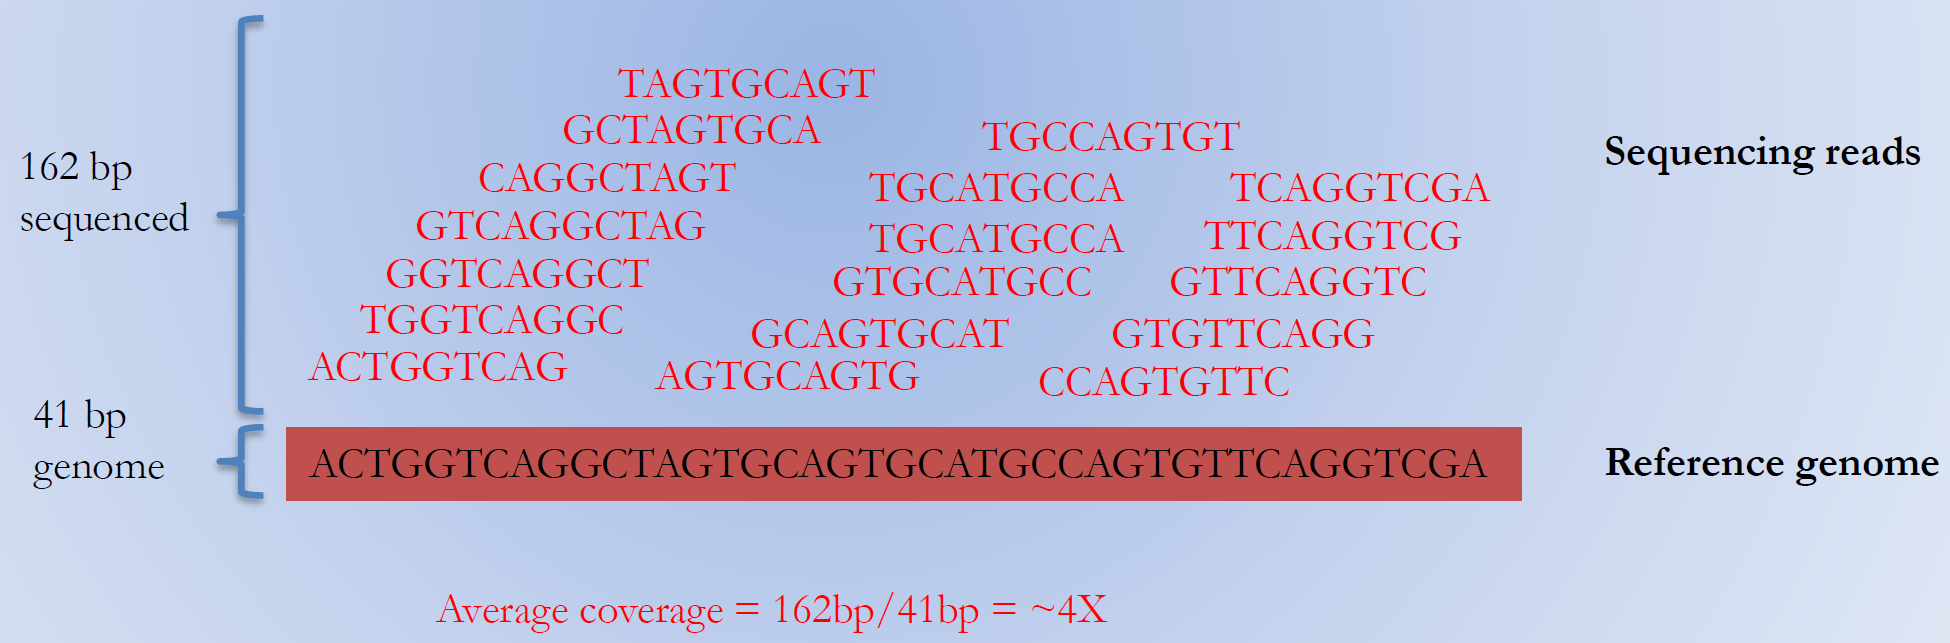

Do:

```
mosdepth -x -n -f /home/local/ANTHROPOLOGY/kuhlwilmm83/refgen/hg19/hg19.p13.plusMT.no_alt_analysis_set.fa test3 test3.markdup.sorted.filtered.bam
```

* Something is wrong - what happened and why?
* What is the meaning of the arguments provided to the program?
 
Now we do it properly and inspect the output!

* What would you have expected?
* What does it tell us about the necessary data in such an experiment?

With the information gathered so far, you will have a good idea on what your data looks like, if it is useful enough information, and if you want to continue or need to do something else.

**This is a very important aspect, and at this stage you may need to summarize the following:**

## (Homework)

* What is the number of raw reads?
* What is the number of reads after adapter removal?
* What is the number of reads after removing unmapped reads & low-quality stuff?
* What is the number of reads after removing duplicates?

You can see the target size of the human genome in the mosdepth output, and the number of bases covered by this sequencing experiment.

* How much more do you need to sequence to get to a high coverage (>10-fold) genome?

A sequencing experiment usually gets you ~1 billion sequencing reads, and may cost ~1,500€ if you are lucky.

* How much would it cost to get this high coverage genome?
